In [1]:
import numpy as np
import cosmosis
%matplotlib inline
import matplotlib.pyplot as plt

# Modules

First we will set up three calculation modules. In a real cosmosis pipeline we would usually read all these modules from files, but here we will make them in a notebook.


## First module


This first module is a simple polynomial of user-definable degree.

In [2]:
def setup(options):
    degree = options.get_int(cosmosis.option_section, "degree")
    return {"degree": degree}


def execute(block, config):
    degree = config['degree']

    coeffs = []
    for i in range(degree+1):
        coeffs.append(block['coefficients', f'p_{i}'])

    # Now we can make the polynomial x and y values,
    x = np.linspace(0, 1, 100)
    y = np.zeros_like(x)
    for i in range(degree+1):
        y += coeffs[i] * x**i
        
    # and store them in the block for later modules
    # to use
    block['poly', 'x'] = x
    block['poly', 'y'] = y

    # we return 0 to indicate that everything worked.
    return 0

poly_module = cosmosis.FunctionModule("poly", setup, execute)
params = {
    "poly": {
        "degree": 2
    }
}

poly_module.setup(params)

## Second Module

This second module computes `y -> y**n`

In [3]:
class PowerModule(cosmosis.ClassModule):
    # This parent class expects that the __init__ method is overridden,
    # matching the setup function in our first module.  
    def __init__(self, options):
        # In this class the options parameter has been trimmed to just be the options
        # specific to this module, so no funny 'cosmosis.options_section' is needed
        # when getting parameters
        self.exponent = options.get_double("exponent")
    
    # The execute method is exactly the same as the previous version
    def execute(self, block):
        block['poly', 'y'] = block['poly', 'y'] ** self.exponent

# The parent class has a method called as_module which converts this to a module
power_module = PowerModule.as_module("power")

## Third Module

This module is a likelihood. By inheriting from the GaussianLikelihood class we can get loads of handy behaviour for free. The only things we need to specify are how to get the measured data at the start, its covariance, and which sections to load the x and y values from.

In [4]:
class Likelihood(cosmosis.GaussianLikelihood):
    # The likelihood will be saved with this name,
    # here target_like
    like_name = "target"

    # The parent class will look for these x and y values
    # in the block, and interpolate the data x and y values to them.
    # If interpolation is not suitable for your likelihood, you can
    # instead override the extract_theory_points method.
    x_section = "poly"
    x_name = "x"
    y_section = "poly"
    y_name = "y"
    
    def __init__(self, options):
        # The parent initializer calls the methods below
        # after setting self.options to this options object
        super().__init__(options)

    # This is called from setup to load or simulate the
    # data for the likelihood
    def build_data(self):
        # Let's make up some fake data to fit our model to
        x = np.array([0.2, 0.31, 0.44, 0.77, 0.9])
        y = (1.4 * x**2 - 3.1 * x - 0.8) ** 2
        return x, y

    # This is also called at the start to load the covariance
    # matrix.  You could also overrride build_inverse_covariance
    # if you have that already.
    def build_covariance(self):
        # We can read parameters from the config like this:
        noise_level = self.options['noise_level']
        sigma = np.array([0.05, 0.06, 0.04, 0.03, 0.1]) * noise_level
        return np.diag(sigma**2)

like_module = Likelihood.as_module("target")

# Module configuration

We now pass in parameters for all the configurable values in the pipeline.  In a command line cosmosis run these would go in the parameters file.

In [5]:

params = {
    "poly": {
        "degree": 2
    },
    "power": {
        "exponent": 2.0,
    },
    "target": {
        "noise_level": 1.0,
    }
}

poly_module.setup(params)
power_module.setup(params)
like_module.setup(params)

modules = [poly_module, power_module, like_module]

# Variables configuration

Now we set up the parameters that vary over the course of the inference, the ones we want to fit. In a command line run these would be stored in the values file.

In [6]:
# The values can either contain individual values for parameters that are fixed,
# or ranges as strings: "min_value   start_value   max_value".
values = {
    "coefficients": {
        "p_0": "0.0   1.0   5.0",
        "p_1": "0.0   1.0   5.0",
        "p_2": "0.0   1.0   5.0",
    }
}

# Pipeline

Now we have all the things we need to run a cosmosis pipeline

In [7]:
pipe = cosmosis.LikelihoodPipeline(params, values=values, modules=modules)

results = pipe.run_results([1.0, 2.0, 3.0])
print(f"Posterior = {results.post}, Likelihood = {results.like}, Prior = {results.prior}")
print(f"Derived parameters = {results.extra}")


Parameter Priors
----------------
coefficients--p_0  ~ U(0.0, 5.0)
coefficients--p_1  ~ U(0.0, 5.0)
coefficients--p_2  ~ U(0.0, 5.0)

Posterior = -120103.04804879359, Likelihood = -120098.21973505628, Prior = -4.828313737302301
Derived parameters = []


# Sampler configuration

We now define all the parameters we need to give to the samplers.  In this case we have two, emugen and emcee.
Emugen is the temporary name I've given to the Boruah-like sampler.


In [8]:
emcee_params = {
    "emcee": {
        "walkers": 64,
        "samples": 500,
        "nsteps": 100,
    },
}

# Emcee Sampling

Now we can run the emcee sampler until it finishes

In [9]:
emcee = cosmosis.samplers.EmceeSampler(emcee_params, pipe)
emcee.config()
while not emcee.is_converged():
    emcee.execute()
    
emcee_chain_full = np.array(emcee.output.rows)


Begun sampling
Done 100 iterations of emcee. Acceptance fraction 0.481
Done 200 iterations of emcee. Acceptance fraction 0.539
Done 300 iterations of emcee. Acceptance fraction 0.559
Done 400 iterations of emcee. Acceptance fraction 0.566
Done 500 iterations of emcee. Acceptance fraction 0.574


# Plot and burn-in the emcee chain 
This helps us choose a burn-in length

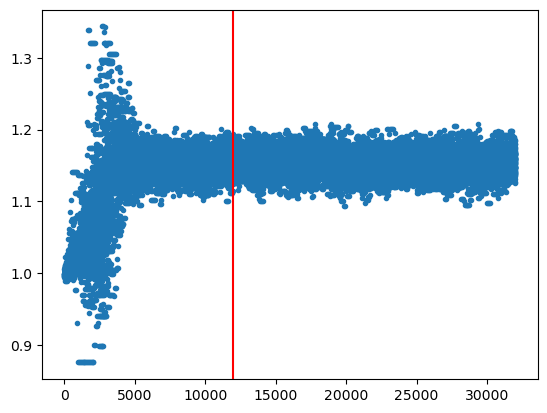

In [10]:
plt.plot(emcee_chain_full[:, 0], '.')
plt.axvline(12000, color='r')

In [11]:
emcee_chain = emcee_chain_full[12000:, :]

# Plot emcee output

Let's look at samples from two of the parameters

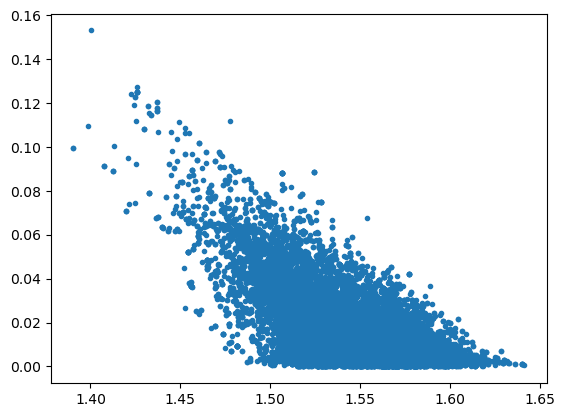

In [12]:
# Plot sample
plt.plot(emcee_chain[:, 1], emcee_chain[:, 2], '.')

# Running the emulator sampler

This is my implementation of Boruah. You can see it doesn't quite work yet, and produces results that are slightly off.

I'm sure we can improve this by tweaking the parameters below - in particular 25 training iterations is very short, and can definitely improve things. Other than that, changing the network design itself will be an important one.


In [13]:
sampler_params = {
    "emugen": {
        "keys": "poly.y",
        "fixed_keys": "poly.x",
        "error_keys": "",
        "initial_size": 900,
        "chi2_cut_off": 1e10,
        "training_iterations": 25,
        "last_emulated_module": "power",
        "tempering": 0.1,
        "iterations": 4,
        "batch_size": 64,
        "resample_size": 1500,
        "emcee_walkers":64,
        "emcee_samples":300, # per walker
        "emcee_burn": 0.3,
        "emcee_thin": 1,
        "seed": 0,
        "mode": "nn",
    },
}

In [14]:
sampler = cosmosis.samplers.EmugenSampler(sampler_params, pipe)
sampler.config()

while not sampler.is_converged():
    sampler.execute()

Computing fiducial data vector
Setting up emulated pipeline. This will print out the parameters again.

Parameter Priors
----------------
coefficients--p_0  ~ U(0.0, 5.0)
coefficients--p_1  ~ U(0.0, 5.0)
coefficients--p_2  ~ U(0.0, 5.0)

Generating initial sample
900 initial samples had chi^2 < cut-off (10000000000.0)
Training emulator (iteration 0 /  4)
Training emulator from 3 parameters -> 100 data vector points on 900 points.


Loss: 0.04385675489902496: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:06<00:00,  3.57it/s]


Running emcee with tempering (0.1) - iteration 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:24<00:00, 12.15it/s]


Reset ...
Selecting 1500 random samples from emcee chain to improve emulator
Running real pipeline on new sample
Training emulator (iteration 1 /  4)
Training emulator from 3 parameters -> 100 data vector points on 2400 points.


Loss: 0.026200849562883377: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:19<00:00,  1.27it/s]


Running emcee with tempering (0.1) - iteration 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:24<00:00, 12.48it/s]


Reset ...
Selecting 1500 random samples from emcee chain to improve emulator
Running real pipeline on new sample
Training emulator (iteration 2 /  4)
Training emulator from 3 parameters -> 100 data vector points on 3900 points.


Loss: 0.0108279874548316: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:33<00:00,  1.35s/it]


Running emcee with tempering (0.1) - iteration 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:27<00:00, 11.08it/s]


Reset ...
Selecting 1500 random samples from emcee chain to improve emulator
Running real pipeline on new sample
Training emulator (iteration 3 /  4)
Training emulator from 3 parameters -> 100 data vector points on 5400 points.


Loss: 0.006125947460532188: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:02<00:00,  2.50s/it]


Running final emcee without tempering - iteration 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:28<00:00, 10.39it/s]


Reset ...


# Plotting Emulator results

And comparing to emcee

In [15]:
chain = np.array(sampler.output.rows)

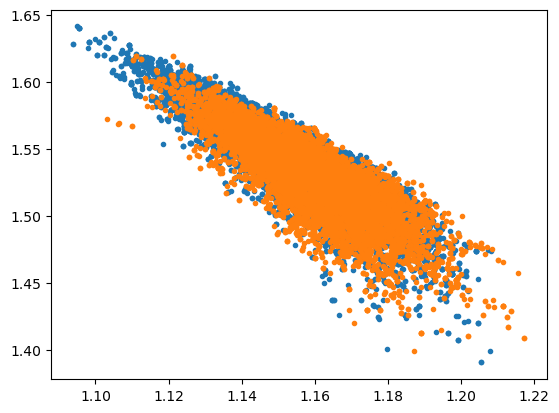

In [16]:
plt.plot(emcee_chain[:, 0], emcee_chain[:, 1], '.')
plt.plot(chain[:, 0], chain[:, 1], '.')

Difference in the means between the chains in units of the std dev.

i.e. number of sigmas wrong that EmuGen currently is!

In [17]:
(chain.mean(0)[:3] - emcee_chain.mean(0)[:3]) / chain.std(0)[:3]

array([ 0.35217261, -0.43933054,  0.29617961])